In [1]:
import os
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import seaborn as sns

In [2]:
# define constants and paths
STANDARD_STEPS = S = 18265
STANDARD_TOKENS = T = 512 * 128 * S
T_MEDIUM = S // 2 * 512 * 256 # due to bigger batch size and rounding of uneven step count, medium size models differ slightly
ORIGINAL_VOCAB_SIZE = 16384

# paths
CACHE_DIR = "cache"
PLOT_DIR = "plots"
for d in [CACHE_DIR, PLOT_DIR]:
    os.makedirs(d, exist_ok=True)
ROOT_DIR = "."
FINETUNE_RESULTS_DIR = f"{ROOT_DIR}/finetune_results"
W2V_RESULTS_DIR = f"{ROOT_DIR}/w2v_results"


WANDB_PROJECT_PATH = "anton-thesis/duplication" # ADD YOUR WANDB PROJECT PATH HERE
def run_id2path(run_id):
    # ADD YOUR WANDB PROJECT PATH HERE
    return f"{WANDB_PROJECT_PATH}/{run_id}"

In [3]:
# setup plotting
import matplotlib

matplotlib.rcParams['font.family'] = 'Palatino'
# Enable LaTeX rendering
plt.rcParams['text.usetex'] = True
latex_path = "/Library/TeX/texbin/"
os.environ["PATH"] += os.pathsep + latex_path

# Include necessary LaTeX packages
plt.rcParams['text.latex.preamble'] = r"""
\usepackage{amsmath}
\usepackage{amsfonts}
\usepackage{amssymb}
"""

PLOT_WIDTH = 4
PLOT_FULL_WIDTH = 6.66
PLOT_HEIGHT = 0.75 * 3.5

def save_plot(name, fig=None, tight_layout=True):
    if fig is None:
        fig = plt.gcf()
    if tight_layout:
        fig.tight_layout()
    fig.savefig(os.path.join(PLOT_DIR, name), bbox_inches='tight', dpi=500)

# Labels
# l for label
l_teff = "\mathrm{TEff}"
l_mlte = "\mathrm{MLTE}"
l_mlpe = "\mathrm{MLPE}"
l_ppl = "\mathrm{PPL}"
l_en1 = "{\mathrm{EN}_1}"
l_en2 = "{\mathrm{EN}_2}"
l_fr = "\mathrm{FR}"
l_en = "\mathrm{EN}"
# lm for label math
lm_teff = "$\mathrm{TEff}$"
lm_mlte = "$\mathrm{MLTE}$"
lm_mlpe = "$\mathrm{MLPE}$"
lm_ppl = "$\mathrm{PPL}$"
lm_en1 = "${\mathrm{EN}_1}$"
lm_en2 = "${\mathrm{EN}_2}$"
lm_fr = "$\mathrm{FR}$"
lm_en = "$\mathrm{EN}$"
def lm_p(x):
    return f"$p({x})$"

# Colors
c_en = "red"
c_en2 = "blue"
c_fr = "blue"

In [4]:
df_runs = pd.read_csv("runs.csv", index_col=0)
df_runs.lang_schedule = df_runs.lang_schedule.fillna("")
display(df_runs)

,frac_clone,p_clone,p_l2,train_steps,tokens,model_size,lang_schedule,num_languages,use_french,ppl_EN1,ppl_EN2,ppl_EN,ppl_FR,merge_vocab,use_clones
run_id,,,,,,,,,,,,,,,
g8nrjdmd,0.0,0.0,0.1,18265,1197015040,small,0.1_0.9,2,True,NaN,NaN,28.904887,19.334022,True,False
axdcp7w3,1.0,0.9,0.0,9312,610271232,small,,2,False,36.172958,25.610470,NaN,NaN,NaN,True
hhkjj1a6,0.0,0.0,0.9,18265,1197015040,small,,2,True,NaN,NaN,43.466156,16.451843,False,False
17rq5dey,1.0,0.5,0.0,9312,610271232,small,,2,False,30.206575,30.249273,NaN,NaN,NaN,True
8x5atmm6,0.0,0.0,0.1,9132,598474752,small,,2,True,NaN,NaN,25.902262,34.879648,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5speagzt,1.0,0.1,NaN,18265,1197015040,small,,2,False,22.459745,32.805344,NaN,NaN,NaN,True
mqs9h1hu,1.0,0.3,NaN,18265,1197015040,small,,2,False,23.948044,29.645971,NaN,NaN,NaN,True
cvaci062,1.0,0.4,NaN,18265,1197015040,small,,2,False,24.969190,27.634183,NaN,NaN,NaN,True


# Compute TEff and MLTE
### Fit Scaling Laws

In [5]:
from plot_utils import PowerLaw

def fit(data_fracs, ppls):
    print("\tFound runs with data fractions", " ".join([f"{f:.2f}" for f in sorted(data_fracs)]))
    plaw = PowerLaw(data_fracs, ppls)
    #plaw.show()
    return plaw

plaws = {}
for model_size in ["small", "mini", "medium"]:
    df_en = df_runs[
        (df_runs.model_size == model_size) & \
        ~df_runs.use_french & \
        ~df_runs.use_clones
    ]
    print("=" * 80)
    print(f"Fitting scaling Law for English, {model_size=}")
    plaws[f"{model_size}_en"] = fit(df_en.tokens / T, df_en.ppl_EN1)
    print()

    print("=" * 80)
    print(f"Fitting scaling Law for French, {model_size=}")
    df_fr = df_runs[
        (df_runs.model_size == model_size) & \
        df_runs.use_french & \
        (df_runs.p_l2 == 1.0)
    ]
    plaws[f"{model_size}_fr"] = fit(df_fr.tokens / T, df_fr.ppl_FR)
    print()

Fitting scaling Law for English, model_size='small'
	Found runs with data fractions 0.05 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.85 0.90 0.95 1.00 1.50 2.00 3.00

Fitting scaling Law for French, model_size='small'
	Found runs with data fractions 0.05 0.10 0.20 0.30 0.40 0.50 0.60 0.70 0.80 0.85 0.90 0.95 1.00 2.00

Fitting scaling Law for English, model_size='mini'
	Found runs with data fractions 0.05 0.10 0.25 0.50 1.00

Fitting scaling Law for French, model_size='mini'
	Found runs with data fractions 0.05 0.10 0.25 0.50 1.00

Fitting scaling Law for English, model_size='medium'
	Found runs with data fractions 0.10 0.24 0.50 1.00 1.20 2.04 2.16 2.28 2.40

Fitting scaling Law for French, model_size='medium'
	Found runs with data fractions 0.10 0.24 0.50 1.00 1.20 2.40



### Figure 5 (Appendix)

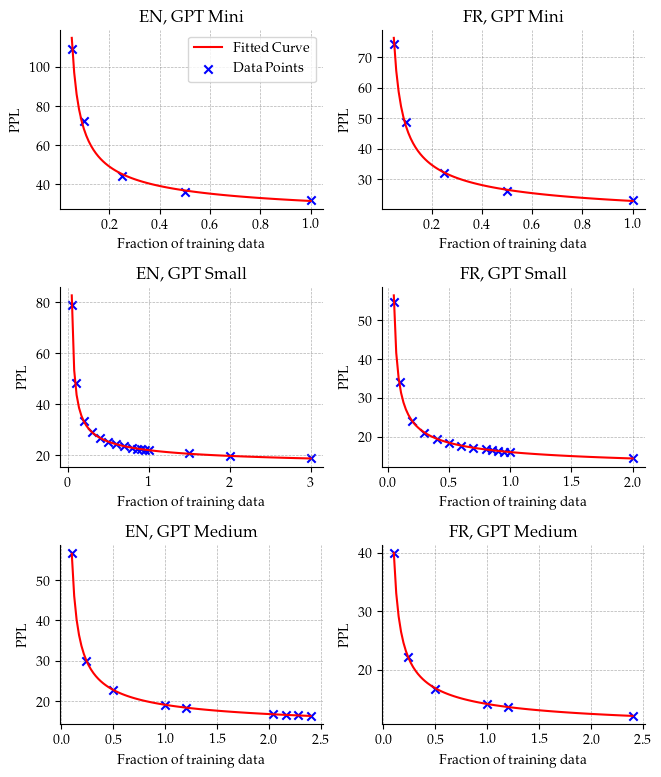

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(PLOT_FULL_WIDTH * 1, PLOT_HEIGHT * 3))
sizes = ["mini", "small", "medium"]

for i, model_size in enumerate(sizes):
    for j, lang in enumerate(["en", "fr"]):
        plaw = plaws[f"{model_size}_{lang}"]
        ax = axs[i, j]
        plaw.plot(ax)
        ax.set_xlabel("Fraction of training data")
        ax.set_ylabel("PPL")
        ax.set_title(f"{lang.upper()}, GPT {model_size.capitalize()}")
        if (i, j) != (0, 0):
            ax.legend().remove()

save_plot("scaling_laws.png")

### Compute Metrics

In [7]:
import math

fr_ratio = df_runs.apply(lambda row: (row.p_l2 if not row.lang_schedule else 0.5) if row.use_french else float("nan"), axis=1) # all used language schedules are overall 50/50
df_runs["tokens_FR"] = np.where(df_runs.use_french, df_runs.tokens * fr_ratio, float("nan"))
df_runs["tokens_EN"] = np.where(df_runs.use_french, df_runs.tokens * (1 - fr_ratio), float("nan"))

en2_ratio = df_runs.apply(lambda row: (row.p_clone / (row.num_languages - 1) if not row.lang_schedule else 0.5) if row.use_clones else float("nan"), axis=1) # all used language schedules are overall 50/50
df_runs["tokens_EN2"] = np.where(df_runs.use_clones, df_runs.tokens * en2_ratio, float("nan"))
df_runs["tokens_EN1"] = np.where(df_runs.use_clones, df_runs.tokens * (1 - (df_runs.num_languages - 1) * en2_ratio), float("nan")) # adjust for number of synthetic languages

In [8]:
# compute mlte
df_runs["mlte_FR"] = df_runs.apply(lambda row: float("nan") if not row.use_french or row.p_l2 == 1 else plaws[f"{row.model_size}_fr"].x(row.ppl_FR) * T, axis=1)
df_runs["mlte_EN"] = df_runs.apply(lambda row: float("nan") if not row.use_french or row.p_l2 == 1 else plaws[f"{row.model_size}_en"].x(row.ppl_EN) * T, axis=1)
df_runs["mlte_EN1"] = df_runs.apply(lambda row: float("nan") if not row.use_clones else plaws[f"{row.model_size}_en"].x(row.ppl_EN1) * T, axis=1)
df_runs["mlte_EN2"] = df_runs.apply(lambda row: float("nan") if not row.use_clones else plaws[f"{row.model_size}_en"].x(row.ppl_EN2) * T, axis=1)

# compute teff
df_runs["teff_FR"] = df_runs.mlte_FR / df_runs.tokens_FR
df_runs["teff_EN"] = df_runs.mlte_EN / df_runs.tokens_EN
df_runs["teff_EN1"] = df_runs.mlte_EN1 / df_runs.tokens_EN1
df_runs["teff_EN2"] = df_runs.mlte_EN2 / df_runs.tokens_EN2


# Cloned Languages

## Overview

### Table 1

In [9]:
# monolingual
df_runs[
    ~df_runs.use_french & \
    ~df_runs.use_clones & \
    df_runs.train_steps.isin([S, S // 2, S // 10]) & \
    (df_runs.model_size == "small")
].sort_values("tokens")[["train_steps", "tokens", "model_size", "ppl_EN1", "ppl_EN2"]]

,train_steps,tokens,model_size,ppl_EN1,ppl_EN2
run_id,,,,,
i8c91m54,1826,119668736,small,48.358189,NaN
qv2qpx8n,9132,598474752,small,25.308240,NaN
3jvt5rjo,18265,1197015040,small,21.930433,NaN


In [10]:
# 2 languages
show_cols = ["p_clone", "train_steps", "tokens", "model_size", "ppl_EN1", "ppl_EN2", "teff_EN1", "teff_EN2"]
df_runs[
    ~df_runs.use_french & \
    (df_runs.train_steps == S) & \
    (df_runs.num_languages == 2) & \
    (df_runs.lang_schedule == "") & \
    df_runs.p_clone.isin([0.5, 0.1]) & \
    (df_runs.frac_clone == 1.0) & \
    (df_runs.model_size == "small")
][show_cols]

,p_clone,train_steps,tokens,model_size,ppl_EN1,ppl_EN2,teff_EN1,teff_EN2
run_id,,,,,,,,
5speagzt,0.1,18265,1197015040,small,22.459745,32.805344,0.999605,2.076345
7wd509ud,0.5,18265,1197015040,small,26.125090,26.136199,0.886629,0.885111


In [11]:
# 10 languages
df_runs[
    ~df_runs.use_french & \
    (df_runs.train_steps == S) & \
    (df_runs.num_languages == 10) & \
    (df_runs.lang_schedule == "") & \
    (df_runs.frac_clone == 1.0) & \
    (df_runs.model_size == "small")
][show_cols + ["num_languages"]]

,p_clone,train_steps,tokens,model_size,ppl_EN1,ppl_EN2,teff_EN1,teff_EN2,num_languages
run_id,,,,,,,,,
uoh7uyqq,0.9,18265,1197015040,small,35.535682,35.739059,1.689081,1.665938,10
goese60a,0.5,18265,1197015040,small,24.566721,33.414951,1.153236,3.555787,10


In [12]:
# schedule
df_runs[
    ~df_runs.use_french & \
    (df_runs.train_steps == S) & \
    (df_runs.num_languages == 2) & \
    (df_runs.lang_schedule != "") & \
    (df_runs.frac_clone == 1.0) & \
    (df_runs.model_size == "small")
][show_cols + ["lang_schedule"]]

,p_clone,train_steps,tokens,model_size,ppl_EN1,ppl_EN2,teff_EN1,teff_EN2,lang_schedule
run_id,,,,,,,,,
0ecgxs9b,0.1,18265,1197015040,small,2.652973e+01,24.435285,0.83405,1.181752,0.1_0.9
21pdcxga,0.0,18265,1197015040,small,9.153151e+10,31.394057,0.04727,0.470562,0.0_1.0


In [13]:
# 2x data
df_runs[
    ~df_runs.use_french & \
    (df_runs.train_steps == 2 * S) & \
    (df_runs.num_languages == 2) & \
    (df_runs.frac_clone == 1.0) & \
    (df_runs.model_size == "small")
][show_cols + ["lang_schedule"]]

,p_clone,train_steps,tokens,model_size,ppl_EN1,ppl_EN2,teff_EN1,teff_EN2,lang_schedule
run_id,,,,,,,,,
ilr4gjnj,0.1,36530,2394030080,small,22.777108,20.423549,0.834545,1.598080,0.1_0.9
w0l5ia89,0.1,36530,2394030080,small,20.060435,23.875490,1.004415,3.293062,
zubg90q7,0.5,36530,2394030080,small,23.345852,23.356490,0.735146,0.733470,


In [14]:
# 3x data
df_runs[
    ~df_runs.use_french & \
    (df_runs.train_steps == 3 * S) & \
    (df_runs.num_languages == 2) & \
    (df_runs.frac_clone == 1.0) & \
    (df_runs.model_size == "small")
][show_cols + ["lang_schedule"]]

,p_clone,train_steps,tokens,model_size,ppl_EN1,ppl_EN2,teff_EN1,teff_EN2,lang_schedule
run_id,,,,,,,,,
cdmviwe8,0.1,54795,3591045120,small,21.500561,19.258220,0.769095,1.630378,0.1_0.9
wlshh0s8,0.1,54795,3591045120,small,19.033202,22.270593,0.994096,3.141136,
fn8m3eg9,0.5,54795,3591045120,small,22.169072,22.178973,0.644389,0.642784,


### Figure 1 (left)

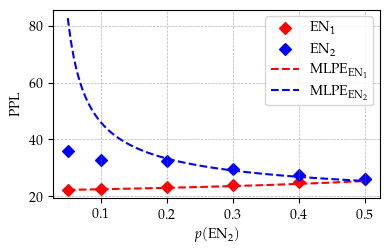

In [15]:
df_plot = df_runs[
    df_runs.use_clones & \
    (df_runs.model_size == "small") & \
    (df_runs.train_steps == S) & \
    (df_runs.num_languages == 2) & \
    (df_runs.frac_clone == 1.0) & \
    (df_runs.lang_schedule == "")
]
marker = "D"

fig, ax = plt.subplots(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
plt.scatter(df_plot.p_clone, df_plot.ppl_EN1, color=c_en, marker=marker, label=lm_en1)
plt.scatter(df_plot.p_clone, df_plot.ppl_EN2, color=c_en2, marker=marker, label=lm_en2)

plt.plot(np.linspace(0.05, 0.5, 100), plaws["small_en"].y(1-np.linspace(0.05, 0.5, 100)), label=f"${l_mlpe}_{l_en1}$", color=c_en, linestyle="--")
plt.plot(np.linspace(0.05, 0.5, 100), plaws["small_en"].y(np.linspace(0.05, 0.5, 100)), label=f"${l_mlpe}_{l_en2}$", color=c_en2, linestyle="--")

ax.set_xlabel(lm_p(l_en2))
ax.set_ylabel(lm_ppl)
ax.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)
ax.legend()

save_plot("ppl_synth_ratio")

## Scale

### Figure 2

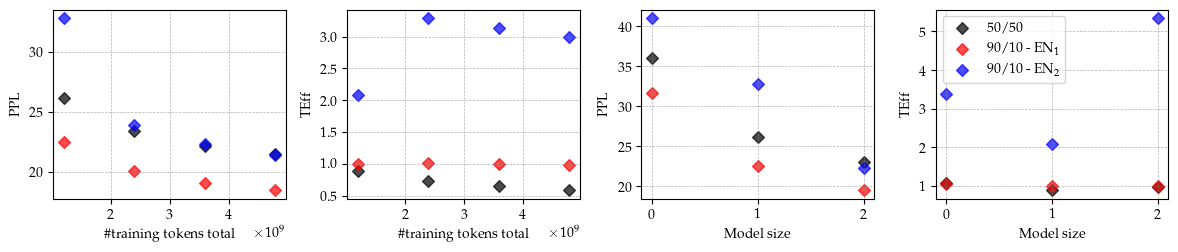

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(PLOT_FULL_WIDTH * 1.8, PLOT_HEIGHT))

pclone_suffix_color_label = [
    (0.5, "EN1", "black", "50/50"),
    (0.1, "EN1", c_en, "90/10 - " + lm_en1),
    (0.1, "EN2", c_en2, "90/10 - " + lm_en2),
]
kwargs = {"marker": "D", "alpha": 0.7}

# vary amount of training steps
df_data = df_runs[
    df_runs.use_clones & \
    (df_runs.model_size == "small") & \
    (df_runs.num_languages == 2) & \
    (df_runs.frac_clone == 1.0) & \
    df_runs.p_clone.isin([0.1, 0.5]) & \
    df_runs.train_steps.isin([S, S * 2, S * 3, S * 4]) & \
    (df_runs.lang_schedule == "")
]
for p_clone, suffix, color, label in pclone_suffix_color_label:
    df_plot = df_data[df_data.p_clone == p_clone]
    axs[0].scatter(df_plot.tokens, df_plot[f"ppl_{suffix}"], color=color, label=label, **kwargs)
    axs[1].scatter(df_plot.tokens, df_plot[f"teff_{suffix}"], color=color, label=label, **kwargs)
axs[0].set_xlabel("\#training tokens total")
axs[0].set_ylabel(lm_ppl)
axs[1].set_xlabel("\#training tokens total")
axs[1].set_ylabel(lm_teff)

# vary model size 
df_model = df_runs[
    df_runs.use_clones & \
    (df_runs.num_languages == 2) & \
    (df_runs.frac_clone == 1.0) & \
    df_runs.p_clone.isin([0.1, 0.5]) & \
    df_runs.tokens.isin([T, T_MEDIUM]) & \
    (df_runs.lang_schedule == "")
].copy()
model_order = {"mini": 0, "small": 1, "medium": 2}
df_model["model_order"] = df_model.model_size.map(model_order)
for p_clone, suffix, color, label in pclone_suffix_color_label:
    df_plot = df_model[df_model.p_clone == p_clone]
    axs[2].scatter(df_plot.model_order, df_plot[f"ppl_{suffix}"], color=color, label=label, **kwargs)
    axs[3].scatter(df_plot.model_order, df_plot[f"teff_{suffix}"], color=color, label=label, **kwargs)
axs[2].set_xlabel("Model size")
axs[3].set_xlabel("Model size")
axs[2].set_xticks(list(model_order.values()))
axs[3].set_xticks(list(model_order.values()))
axs[2].set_ylabel(lm_ppl)
axs[3].set_ylabel(lm_teff)
axs[3].legend()

for ax in axs:
    ax.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)

save_plot("fakelang_scaling.png")

### Figure 9 (Appendix)

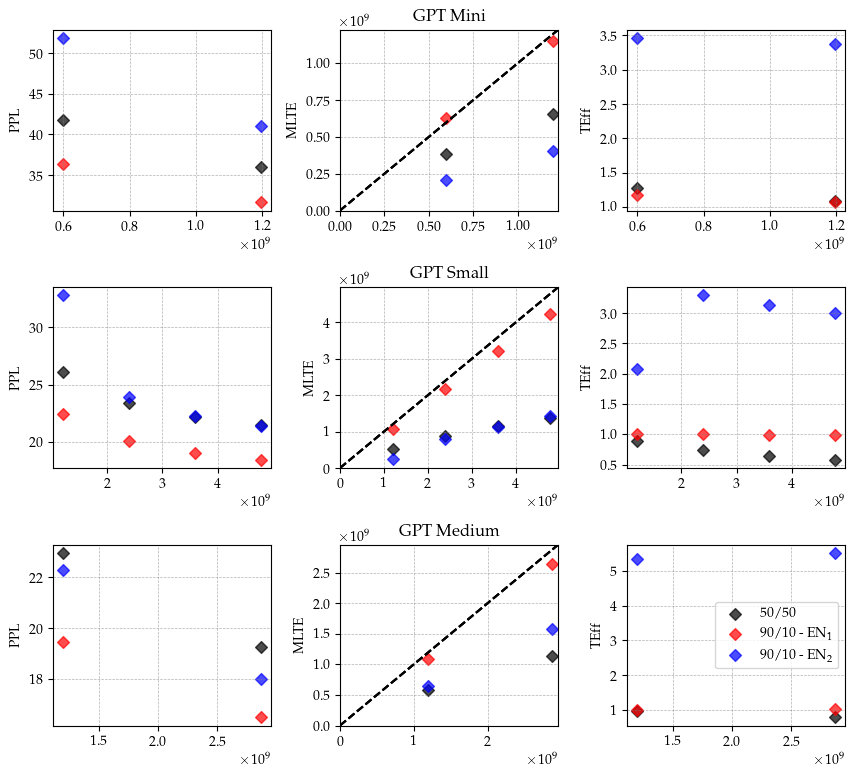

In [17]:
fig, axs_all = plt.subplots(len(sizes), 3, figsize=(PLOT_FULL_WIDTH * 1.3, 3 * PLOT_HEIGHT))

pclone_suffix_color_label = [
    (0.5, "EN1", "black", "50/50"),
    (0.1, "EN1", c_en, "90/10 - " + lm_en1),
    (0.1, "EN2", c_en2, "90/10 - " + lm_en2),
]
kwargs = {"marker": "D", "alpha": 0.7}

df_data = df_runs[
    df_runs.use_clones & \
    (df_runs.num_languages == 2) & \
    (df_runs.frac_clone == 1.0) & \
    df_runs.p_clone.isin([0.1, 0.5]) & \
    (
        ((df_runs.model_size == "mini") & df_runs.train_steps.isin([S // 2, S])) | \
        ((df_runs.model_size == "small") & df_runs.train_steps.isin([S, S * 2, S * 3, S * 4])) | \
        ((df_runs.model_size == "medium") & df_runs.train_steps.isin([S // 2, 21908])) # medium model has 2x batch size
    ) & \
    (df_runs.lang_schedule == "")
]

for i, model_size in enumerate(["mini", "small", "medium"]):
    axs = axs_all[i]
    for p_clone, suffix, color, label in pclone_suffix_color_label:
        df_plot = df_data[(df_data.model_size == model_size) & (df_data.p_clone == p_clone)]

        axs[0].set_ylabel(lm_ppl)
        axs[0].scatter(df_plot.tokens, df_plot[f"ppl_{suffix}"], color=color, label=label, **kwargs)
        axs[1].set_ylabel(lm_mlte)
        axs[1].scatter(df_plot.tokens, df_plot[f"mlte_{suffix}"], color=color, label=label, **kwargs)
        axs[2].set_ylabel(lm_teff)
        axs[2].scatter(df_plot.tokens, df_plot[f"teff_{suffix}"], color=color, label=label, **kwargs)

        # make mlte axis equal and plot diagonal
        t_max = max(axs[1].get_xlim()[1], axs[1].get_ylim()[1])
        axs[1].set_ylim((0, t_max))
        axs[1].set_xlim((0, t_max))
        axs[1].plot([0, t_max], [0, t_max], color="k", linestyle="--")

        # label in middle plot
        axs[1].set_title(f"GPT {model_size.capitalize()}")

    for ax in axs:
        ax.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)

axs_all[-1, -1].legend()
save_plot("fakelang_scaling_all.png")


## GLUE

In [18]:
import json

df_glue = df_runs[
    df_runs.use_clones & \
    (df_runs.train_steps == S) & \
    (df_runs.num_languages == 2) & \
    (df_runs.frac_clone == 1.0) & \
    (df_runs.model_size == "small") & \
    (df_runs.lang_schedule == "")
].copy()

print(df_glue.index)

# read results from GLUE finetuning
for dirname in os.listdir(FINETUNE_RESULTS_DIR):
    runid = dirname.split("_")[-1]

    # read accuracies of all tasks in L1 (w) and L2 (w')
    l1_accs, l2_accs = [], []
    run_dir = os.path.join(FINETUNE_RESULTS_DIR, dirname)
    for task in os.listdir(run_dir):
        with open(os.path.join(run_dir, task, "eval_L1_results.json"), "r") as f:
            l1_accs.append(float(json.loads(f.read())["eval_accuracy"]))
        l2_res_path = os.path.join(run_dir, task, "eval_L2_results.json")
        if os.path.exists(l2_res_path):
            with open(l2_res_path, "r") as f:
                l2_accs.append(float(json.loads(f.read())["eval_accuracy"]))
        else:
            # models that aren't trained with duplication don't have L2 results
            l2_accs.append(float("nan"))

    df_glue.at[runid, "GLUE_EN1"] = np.mean(l1_accs)
    df_glue.at[runid, "GLUE_EN2"] = np.mean(l2_accs)

colnames = ["p_clone", "GLUE_EN1", "GLUE_EN2"]
for col_name in colnames:
    df_glue[col_name] = df_glue[col_name].apply(lambda x: round(x, 2))
display(df_glue[colnames])

Index(['1oiczdjt', 'h1fhszd6', '5speagzt', 'mqs9h1hu', 'cvaci062', '7wd509ud'], dtype='object', name='run_id')


,p_clone,GLUE_EN1,GLUE_EN2
run_id,,,
1oiczdjt,0.05,0.71,0.64
h1fhszd6,0.20,0.71,0.58
5speagzt,0.10,0.71,0.65
mqs9h1hu,0.30,0.70,0.52
cvaci062,0.40,0.71,0.53
7wd509ud,0.50,0.70,0.54


### Figure 1 (right)

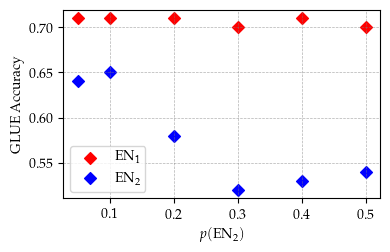

In [19]:
fig, ax = plt.subplots(figsize=(PLOT_WIDTH, PLOT_HEIGHT))
marker = "D"

ax.scatter(df_glue.p_clone, df_glue.GLUE_EN1, color=c_en, marker=marker, label=lm_en1)
ax.scatter(df_glue.p_clone, df_glue.GLUE_EN2, color=c_en2, marker=marker, label=lm_en2)
ax.set_ylabel("GLUE Accuracy")
ax.set_xlabel(lm_p(l_en2))
ax.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)
ax.legend()

save_plot("glue_synth_ratio")

## Anchor Points

### Figure 8 (Appendix)

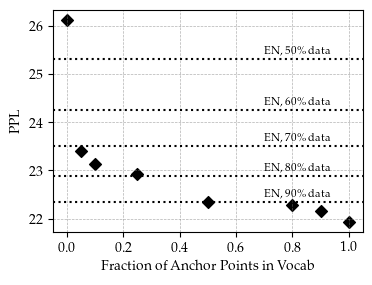

In [20]:
fig, ax = plt.subplots(figsize=(PLOT_WIDTH, PLOT_HEIGHT * 1.1))

df_plot = df_runs[
    ~df_runs.use_french & \
    (df_runs.train_steps == S) & \
    (df_runs.num_languages == 2) & \
    (df_runs.lang_schedule == "") & \
    ((df_runs.p_clone == 0.5) | ((df_runs.p_clone == 0.0) & (df_runs.frac_clone == 0))) & \
    (df_runs.model_size == "small")
]

ax.scatter(1 - df_plot.frac_clone, df_plot.ppl_EN1, marker="D", color="k")

ax.set_xlabel("Fraction of Anchor Points in Vocab")
ax.set_ylabel("PPL")
ax.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)


# draw horizontal lines showing performance of 85%, 90%, 95% training
yshift = 0.15
for percent_data in [50, 60, 70, 80, 90]:
    df_relevant = df_runs[
        (df_runs.train_steps == int(percent_data/100 * STANDARD_STEPS)) & \
        (df_runs.model_size == "small") & \
        ~df_runs.use_french & \
        ~df_runs.use_clones
    ]
    assert len(df_relevant) == 1
    ppls = df_relevant.ppl_EN1.values[0]
    label = "EN, " + str(percent_data) + "\\% data"
    ax.axhline(ppls, color="k", linestyle="dotted")
    ax.text(0.7, ppls + yshift, label, fontsize=8, verticalalignment='center')

## Embeddings & Word2vec

In [55]:
from languini.common_lib.experiment_utils import load_wandb_file
import torch.nn.functional as F
import pickle


def get_subword_embeddings(run_path, device="cpu", output_embeddings=False):
    checkpoint = torch.load(load_wandb_file(run_path, "checkpoints/model.pt", cache_dir=CACHE_DIR), map_location=device)
    if output_embeddings:
        return checkpoint["model_state_dict"]["module._orig_mod.linear.weight"]
    else:
        return checkpoint["model_state_dict"]["module._orig_mod.input_embedding.weight"]


def compute_clones_cosine_similarities(emb):
    """
    Assumes frac_duplicated = 1.0 and vocab_size = 16384
    """
    vocab_size = 16384
    # sim = F.cosine_similarity(emb.unsqueeze(1), emb.unsqueeze(0), dim=-1) crashes kernel due to OOM
    emb_normed = emb / emb.norm(dim=1, keepdim=True)
    sim = emb_normed @ emb_normed.T
    # compare subwords and their clones
    sim_all_clones = sim.diag(vocab_size)
    result = {
        "any": float(sim.nanmean()),
        "clones": float(sim_all_clones.nanmean()), 
        "clones_all": sim_all_clones.cpu().numpy(),
    }
    return result


def compute_gpt_clones_cosine_similarities(run_path):
    # load from cache if available
    run_id = run_path.split("/")[-1]
    cache_path = os.path.join(CACHE_DIR, run_id, "cossim.pkl")
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            return pickle.load(f)

    emb_in = get_subword_embeddings(run_path)
    result = {k + "_in": v for k, v in compute_clones_cosine_similarities(emb_in).items()}
    emb_out = get_subword_embeddings(run_path, output_embeddings=True)
    result.update({k + "_out": v for k, v in compute_clones_cosine_similarities(emb_out).items()})

    # store in cache
    with open(cache_path, "wb") as f:
        pickle.dump(result, f)

    return result

In [56]:
df_sim = df_runs[
    df_runs.use_clones & \
    (df_runs.train_steps == S) & \
    (df_runs.num_languages == 2) & \
    (df_runs.frac_clone == 1.0) & \
    (df_runs.model_size == "small") & \
    (df_runs.lang_schedule == "")
].copy()
# create columns with type object to store arrays
df_sim["sim_clones_all_in"], df_sim["sim_clones_all_out"] = None, None

for run_id, row in tqdm(df_sim.iterrows(), total=len(df_sim)):
    run_path = run_id2path(run_id)
    assert row.frac_clone == 1.0, "only implemented for frac_clone=1.0"
    for k, v in compute_gpt_clones_cosine_similarities(run_path).items():
        df_sim.at[run_id, f"sim_{k}"] = v

  0%|          | 0/6 [00:00<?, ?it/s]

### Figure 6 (Appendix)

In [57]:
# load word2vec results
def compute_w2v_clones_cosine_similarities(w2v_dir):
    # load from cache if available
    w2v_id = "w2v_" + w2v_dir.split("/")[-1]
    cache_path = os.path.join(CACHE_DIR, w2v_id, "cossim.pkl")
    if os.path.exists(cache_path):
        with open(cache_path, "rb") as f:
            return pickle.load(f)

    emb_in = torch.load(os.path.join(w2v_dir, "input_embeddings.pt"))
    result = {k + "_in": v for k, v in compute_clones_cosine_similarities(emb_in).items()}
    emb_out = torch.load(os.path.join(w2v_dir, "output_embeddings.pt"))
    result.update({k + "_out": v for k, v in compute_clones_cosine_similarities(emb_out).items()})

    # store in cache
    os.makedirs(os.path.dirname(cache_path), exist_ok=True)
    with open(cache_path, "wb") as f:
        pickle.dump(result, f)

    return result


# create columns with type object to store arrays
df_sim["w2v_sim_clones_all_in"], df_sim["w2v_sim_clones_all_out"] = None, None
for run_id, row in tqdm(df_sim.iterrows(), total=len(df_sim)):
    run_path = run_id2path(run_id)
    # find corresponding word2vec run
    w2v_dir = f"{W2V_RESULTS_DIR}/{row.frac_clone}_{row.p_clone}_0"
    for k, v in compute_w2v_clones_cosine_similarities(w2v_dir).items():
        df_sim.at[run_id, f"w2v_sim_{k}"] = v

  0%|          | 0/6 [00:00<?, ?it/s]

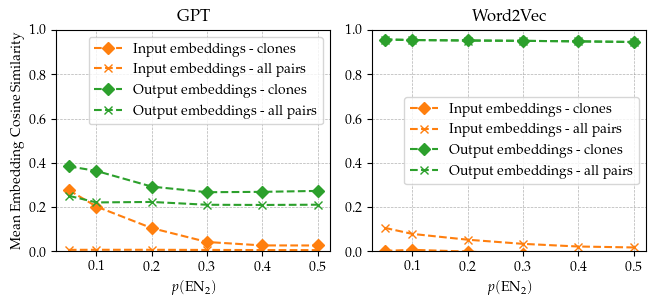

In [58]:
fig, axs = plt.subplots(figsize=(PLOT_FULL_WIDTH, PLOT_HEIGHT * 1.2), ncols=2)
cmap = plt.get_cmap("tab10")

linestyle = "--"
df_sim = df_sim.sort_values(by="p_clone")

for ax, title, prefix in zip(axs, ["GPT", "Word2Vec"], ["", "w2v_"]):
    for io_title, io_id, io_color in zip(["Input", "Output"], ["in", "out"], [cmap(1), cmap(2)]):
        for dup_title, dup_id, dup_marker in zip(["clones", "all pairs"], ["clones", "any"], ["D", "x"]):
            key = f"{prefix}sim_{dup_id}_{io_id}"
            ax.plot(df_sim.p_clone, df_sim[key], label=f"{io_title} embeddings - {dup_title}", marker=dup_marker, color=io_color, linestyle=linestyle)

    ax.set_title(title)
    ax.set_xlabel(lm_p(l_en2))
    ax.set_ylim([0, 1])
    ax.legend()
    ax.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)

axs[0].set_ylabel("Mean Embedding Cosine Similarity")

save_plot("cossim_synth_ratio.png")

### Figure 7 (Appendix)

In [62]:
# compute token frequencies in training data
from languini.dataset_lib.languini_books import LanguiniDatasetIterator
from languini.train_lib import train_utils

cache_file = os.path.join(CACHE_DIR, "train_frequencies.npy")

if os.path.exists(cache_file):
    # load from cache
    train_frequencies = np.load(cache_file)
else:
    # compute frequencies
    END_OF_DOC_TOKEN = 2
    seq_len = 512
    train_batch_size = 128
    device = "cpu"
    dataset = "books_16384"
    full_data_path = os.path.join(ROOT_DIR, "data/books", dataset)

    train_ds = LanguiniDatasetIterator(
        data_path=full_data_path,
        split='train',
        repeat=True,
        global_batch_size=train_batch_size,
        batch_idxs=list(range(train_batch_size)),
        micro_batches=1,
        sequence_length=seq_len,
        device=device,
        end_of_doc_token=END_OF_DOC_TOKEN,
        sp=train_utils.load_tokeniser(name=dataset)
    )

    train_frequencies = torch.zeros(ORIGINAL_VOCAB_SIZE, device=device)
    for step in tqdm(range(STANDARD_STEPS)):
        total_batch_x, total_batch_y, _ = next(train_ds)
        for batch_y in total_batch_y:
            train_frequencies += torch.bincount(batch_y.reshape(-1), minlength=ORIGINAL_VOCAB_SIZE)
    train_frequencies = train_frequencies.numpy()

    # store in cache
    np.save(cache_file, train_frequencies)

load vocab from: /Users/anton/Repositories/fork-languini-kitchen/languini/vocabs/spm_models/books_16384.model


  0%|          | 0/18265 [00:00<?, ?it/s]

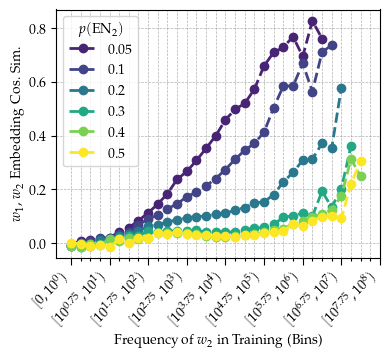

In [64]:
from plot_utils import BinPlot
from matplotlib import colors as mcolors

occ_mask = train_frequencies > 0
bin_plot = BinPlot(x_all=train_frequencies[occ_mask])

# normalize p_dup for colormap
norm = mcolors.Normalize(vmin=0, vmax=0.5)
cmap = plt.cm.viridis

fig, ax = plt.subplots(1, 1, figsize=(PLOT_WIDTH, 1.4 * PLOT_HEIGHT))
for i, row in df_sim.sort_values(by="p_clone").iterrows():
    x, y = train_frequencies[occ_mask], row.sim_clones_all_in[occ_mask]
    x = x * row.p_clone
    ax.plot(*bin_plot.to_bins(x, y), color=cmap(norm(row.p_clone)), linewidth=2, linestyle="--", marker="o", label="$" + str(row.p_clone) + "$")

ax.set_ylabel("$w_1$, $w_2$ Embedding Cos. Sim.")
ax.set_xlabel(f"Frequency of $w_2$ in Training (Bins)")
ax.set_xticks(*bin_plot.get_ticks_labels(), rotation=45, ha="right")
bin_plot.adjust_tick_lengths(ax)
ax.grid(True, linestyle='--', color='grey', linewidth=0.5, alpha=0.6)
ax.legend()
ax.legend(title=lm_p(l_en2))
save_plot("cossim_by_freq_synth_ratio.png")

## Hidden State & Gradient Similarities

### Table 2

### Figure 11 (Appendix)

# Real Languages (English & French)

## Overview

### Table 3

### Figure 3

## Scale

### Figure 4

### Figure 10 (Appendix)

## Hidden State & Gradient Similarities

### Table 4

### Figure 12 & 13 (Appendix)